# How Many Log Errors Does it Take to Predict Home Value?
---
by Kevin smith 8/9/2022

## Project Goal
---
The goal of this project is to develop a model that utilizes clustering and log error and outperforms the baseline prediction, and develop recommendations for ways that the model can be improved and deployed. 

This goal will be accomplished utilizing the following steps:

* Planning
* Acqusition
* Prep
* Exploration
* Clustering
* Feature Engineering
* Modeling
* Delivery

In [1]:
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from env import host, username, password
import os
import wrangle
import explore
import model
import numpy as np
from matplotlib import cm

from sklearn.model_selection import learning_curve

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, LassoLars
from sklearn.metrics import mean_squared_error
from sklearn.kernel_ridge import KernelRidge
import warnings
warnings.filterwarnings("ignore")

## Wrangle
---
I have combined the acquire and prep steps into one with wrangle. In this step we acquire, clean, prep, and split the data set to prepare it for exploration. 

In [2]:
# I dropped the nulls for the sake of quickness, and handled outliers based on boxplots built on each variable
# then i split the data utilizing random_state=123 to ensure consistent results

train, validate, test = wrangle.wrangle_zillow()

In [3]:
# i scaled the continuous variables and left the categoricals, and the target variable the same

train_scaled, validate_scaled, test_scaled = wrangle.prep(train,validate,test)

## Exploration
---
I looked for any non-linear relationships between features that may be useful when predicting my target variable

## Clustering
--- 
as part of my exploration process i clustered on features that i found to have some type of dependencies.

H0: latitude and land_cost/sqf are not dependent
Ha: latitude and land_cost/sqf are dependent

In [4]:
# do latitude, and longitude have a dependent relationship with land cost?
corr, p = stats.pearsonr(train_scaled.scaled_latitude, train_scaled['scaled_land_cost/sqf'])

if p < .05 and (corr > .25 or corr < -.25):
    print(f'with a p score of {p} and a correlation of {corr:.2} means that we can confidently say that the variables are correlated.')
else:
    print(f'we cannot be confident that the variables are correlated. {p,corr}')
    
corr, p = stats.pearsonr(train_scaled.scaled_longitude, train_scaled['scaled_land_cost/sqf'])

with a p score of 0.0 and a correlation of -0.28 means that we can confidently say that the variables are correlated.


H0: longitude and land_cost/sqf are not dependent
Ha: longitude and land_cost/sqf are dependent

we cannot be confident that the variables are correlated. (1.0957288948924923e-26, 0.06333002522288043)


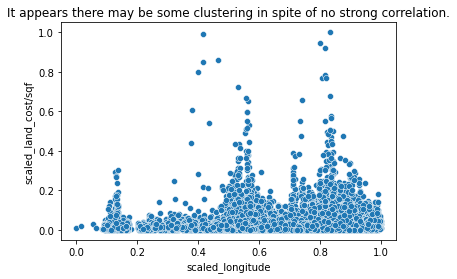

In [5]:
corr, p = stats.pearsonr(train_scaled.scaled_longitude, train_scaled['scaled_land_cost/sqf'])
if p < .05 and (corr > .25 or corr < -.25):
    print(f'a p score of {p} and a correlation of {corr:.2} means that we can confidently say that the variables are correlated.')
else:
    print(f'we cannot be confident that the variables are correlated. {p,corr}')
    
sns.scatterplot(data=train_scaled, x='scaled_longitude',y='scaled_land_cost/sqf')
plt.title('It appears there may be some clustering in spite of no strong correlation.')
plt.show()

# although the statistical test didnt show a strong linear correlation between latitude and land cost,
# there does appear to be a non_linear relationship. clustering may be needed.

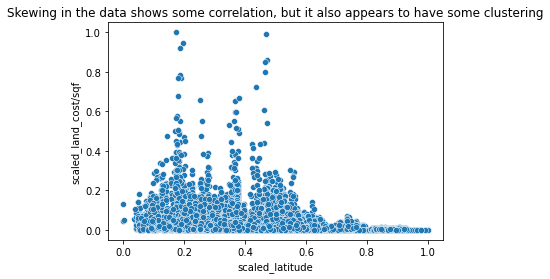

In [6]:
sns.scatterplot(data=train_scaled, x='scaled_latitude',y='scaled_land_cost/sqf')
plt.title('Skewing in the data shows some correlation, but it also appears to have some clustering')
plt.show()

Text(0.5, 1.0, 'plotting lat vs long gives us the coast-line')

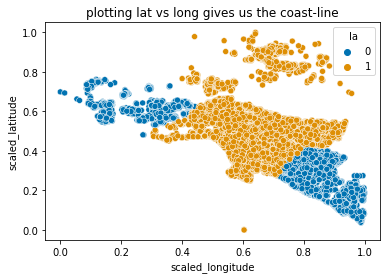

In [7]:
sns.scatterplot(data=train_scaled, x='scaled_longitude',y='scaled_latitude', hue = 'la', palette='colorblind')
plt.title('plotting lat vs long gives us the coast-line')

In [8]:
# clustering based on location may yield results

cluster_vars=['scaled_latitude','scaled_longitude','city_id']
cluster_name = 'area_cost'
k_range = range(2,25)

kmeans = KMeans(n_clusters = 5, random_state=123)
kmeans.fit(train_scaled[cluster_vars])
train_scaled["location"] = kmeans.predict(train_scaled[cluster_vars])
validate_scaled["location"] = kmeans.predict(validate_scaled[cluster_vars])
test_scaled["location"] = kmeans.predict(test_scaled[cluster_vars])

H0: acres and home_cost/sqf are not dependent
Ha: acres and home_cost/sqf are dependent

In [9]:
# do acres have a dependent relationship with home cost?
corr, p = stats.pearsonr(train_scaled.scaled_acres, train_scaled['scaled_home_cost/sqf'])

if p < .05 and (corr > .25 or corr < -.25):
    print(f'with a p score of {p} and a correlation of {corr:.2} means that we can confidently say that the variables are correlated.')
else:
    print(f'we cannot be confident that the variables are correlated. {p,corr}')
 

we cannot be confident that the variables are correlated. (2.507322911935449e-38, 0.07663073933980999)


H0: square feet and home_cost/sqf are not dependent
Ha: square feet and home_cost/sqf are dependent

a p score of 0.0 and a correlation of 0.34 means that we can confidently say that the variables are correlated.


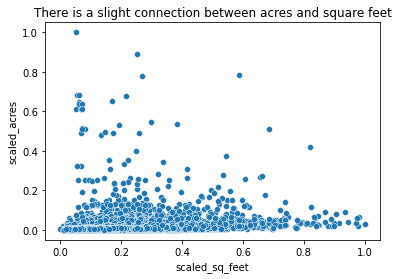

In [10]:
# do sqare feet have a dependent relationship with home cost?   
corr, p = stats.pearsonr(train_scaled.scaled_sq_feet, train_scaled['scaled_home_cost/sqf'])


if p < .05 and (corr > .25 or corr < -.25):
    print(f'a p score of {p} and a correlation of {corr:.2} means that we can confidently say that the variables are correlated.')
else:
    print(f'we cannot be confident that the variables are correlated. {p,corr}')
    
sns.scatterplot(data=train_scaled, x='scaled_sq_feet',y='scaled_acres')
plt.title('There is a slight connection between acres and square feet')
plt.show()

# although the statistical test didnt show a strong linear correlation between latitude and land cost,
# there does appear to be a non_linear relationship. clustering may be needed.

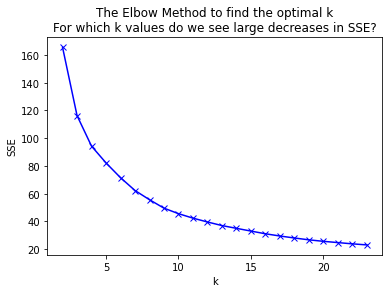

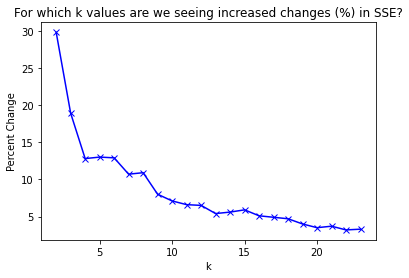

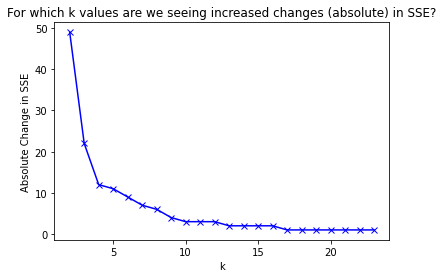

In [11]:
#since square feet has some correlation with both acres and home_cost, i clustered on all 3
cluster_vars=['scaled_sq_feet','scaled_acres','scaled_home_cost/sqf']

k_range = range(2,25)

explore.find_k(train_scaled,cluster_vars,k_range)

kmeans = KMeans(n_clusters = 7, random_state=123)
kmeans.fit(train_scaled[cluster_vars])
train_scaled["area_home_cost"] = kmeans.predict(train_scaled[cluster_vars])
validate_scaled["area_home_cost"] = kmeans.predict(validate_scaled[cluster_vars])
test_scaled["area_home_cost"] = kmeans.predict(test_scaled[cluster_vars])

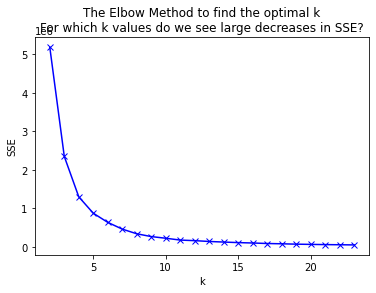

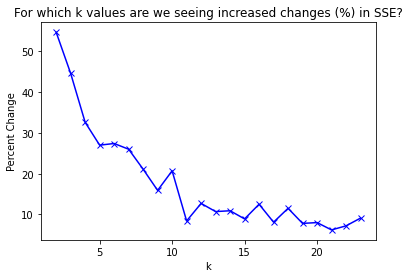

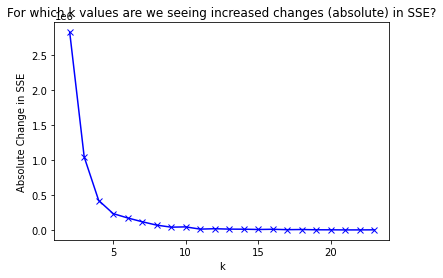

In [12]:
# on a hunch i also clustered age, bed_bath_ratio, and home cost
cluster_vars=['age','bed_bath_ratio','scaled_home_cost/sqf']

k_range = range(2,25)

explore.find_k(train_scaled,cluster_vars,k_range)   

kmeans = KMeans(n_clusters = 5, random_state=123)
kmeans.fit(train_scaled[cluster_vars])
train_scaled["age_bed_cost"] = kmeans.predict(train_scaled[cluster_vars])
validate_scaled["age_bed_cost"] = kmeans.predict(validate_scaled[cluster_vars])
test_scaled["age_bed_cost"] = kmeans.predict(test_scaled[cluster_vars])

<function matplotlib.pyplot.show(close=None, block=None)>

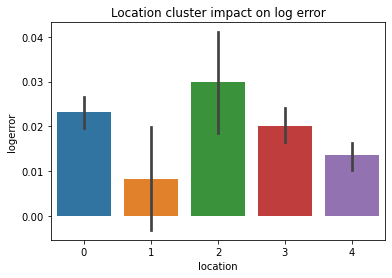

In [13]:

sns.barplot(data=train_scaled, x='location',y='logerror')
plt.title('Location cluster impact on log error')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

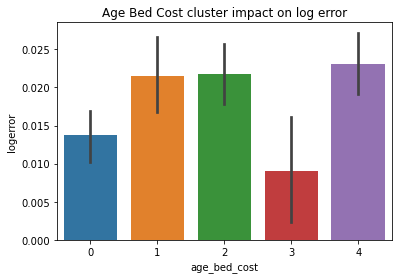

In [14]:

sns.barplot(data=train_scaled, x='age_bed_cost',y='logerror')
plt.title('Age Bed Cost cluster impact on log error')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

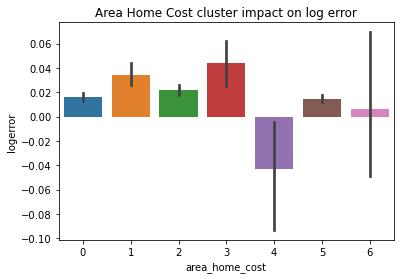

In [15]:

sns.barplot(data=train_scaled, x='area_home_cost',y='logerror')
plt.title('Area Home Cost cluster impact on log error')
plt.show

### exploration summary
---
we discovered 3 sets of 3 variables that have some form or correlation to one another that may have an impact on our target variable, and we created clusters for each of those sets. 

From here we can run a feature engineering algorithm to determine if our models will find our clusters useful.

## Modeling
---
Making predictions about log error and evaluating my accuracy

In [16]:
# i converted my clusters into dummy variables to make them more useful in modeling
def get_dummies(df,dummy_vars):
    for i in dummy_vars:
        dummies = pd.get_dummies(df[i],drop_first=True)
        df = pd.concat([df,dummies],axis=1)
        df = df.drop(columns=i)
        return df
        
dummy_vars = ['area_home_cost']

train_scaled = get_dummies(train_scaled,dummy_vars)
validate_scaled = get_dummies(validate_scaled,dummy_vars)
test_scaled = get_dummies(test_scaled,dummy_vars)

In [17]:
# splitting the target variable awauy from the rest of the data

x_train_scaled = train_scaled.drop(columns='logerror')
y_train_scaled = pd.DataFrame(train_scaled.logerror)

x_validate_scaled = validate_scaled.drop(columns='logerror')
y_validate_scaled = pd.DataFrame(validate_scaled.logerror)

x_test_scaled = test_scaled.drop(columns='logerror')
y_test_scaled = pd.DataFrame(test_scaled.logerror)

In [18]:
# do my clusters make any difference? no they dont.

from sklearn.feature_selection import SelectKBest, f_regression

f_selector = SelectKBest(f_regression, k=18)

f_selector.fit(x_train_scaled, y_train_scaled)

feature_mask = f_selector.get_support()

f_feature = x_train_scaled.iloc[:,feature_mask].columns.tolist()
f_feature

['parcelid',
 'bed',
 'bath',
 'zip',
 'year',
 'la',
 'orange',
 'age',
 'scaled_sq_feet',
 'scaled_latitude',
 'scaled_longitude',
 'scaled_land_value',
 'scaled_home_cost/sqf',
 'location',
 1,
 3,
 4,
 5]

In [19]:
#what is the score to beat? 

model.baseline(y_train_scaled,y_validate_scaled, y_test_scaled)

RMSE using Mean
Train/In-Sample:  0.16690221961201632 
Validate/Out-of-Sample:  0.1714646972037276 
Test/Out-of-Sample:  0.1965547402621701


In [20]:
model.linear(x_train_scaled,y_train_scaled, y_validate_scaled,x_validate_scaled,x_test_scaled, y_test_scaled)

RMSE for OLS using LinearRegression
Training/In-Sample:  0.16631725022498905 
Validation/Out-of-Sample:  0.17152307755780838 
Test/ Out-of-Sample:  0.1963564927763893
0.001355033039205906
The linear model performed 0.14% better than the baseline when predicting log error.


In [21]:
model.lasso(x_train_scaled,y_train_scaled, y_validate_scaled,x_validate_scaled)

RMSE for OLS using LinearRegression
Training/In-Sample:  0.16690221961201632 
Validation/Out-of-Sample:  0.17146469720372756


In [22]:
model.poly(x_train_scaled,y_train_scaled, y_validate_scaled,x_validate_scaled,x_test_scaled, y_test_scaled)

RMSE for OLS using LinearRegression
Training/In-Sample:  0.16631725022498905 
Validation/Out-of-Sample:  0.17152307755780838 
Test/ Out-of-Sample:  0.1963564927763893
0.001355033039205906
The polynomial model performed 0.14% better than the baseline when predicting log error.


## Conclusion
---

- I found that my clusters in their current forms do no yield impactful results. I would like to explore further.

- The trouble with predicting something on a spectrum like log error is that the line of best fit will likely be around zero regardless of the model type.

- it may be useful to predict if a log error will be positive or negative and then make a further prediction to determine by how much. 